In [6]:
import numpy as np
from math import sqrt
import copy
import scipy.linalg
import matplotlib.pyplot as plt
import random

In [7]:
class gelasticnetSover(object):

    def mulup_solve(self,Amat, lowbo,upbo, bvec,err_tol = 1e-8, text='Off', text_fr=200):
        A_plus = copy.deepcopy(Amat)
        A_plus[A_plus<0]=0

        A_minus = copy.deepcopy(Amat)
        A_minus[A_minus>0]=0
        A_minus = abs(A_minus)

        v = np.array([1.0 for x in range(len(bvec))])
        
        old_v = np.array([0 for x in range(len(bvec))])
        updateFactor = np.array([0.0 for x in range(len(bvec))])
        count=0
        while(((old_v-v)**2).sum()>err_tol):
            dFa = np.array(A_plus.dot(v))
            dFb = copy.deepcopy(bvec)
            dFc = np.array(A_minus.dot(v))
            for i in range(len(bvec)):
                updateFactor[i] = float((-dFb[i]+sqrt(dFb[i]**2+4*dFa[i]*dFc[i]))/(2*dFa[i]))

            if np.count_nonzero(~np.isnan(updateFactor)) ==len(bvec):
                old_v = copy.deepcopy(v)
                beta = np.maximum(np.minimum(upbo, (updateFactor * v)[:int(len(v)/2)]-(updateFactor * v)[int(len(v)/2):]), lowbo)
                v=[max(item,0) for item in beta]+[abs(min(item,0)) for item in beta]
                v=np.array(v)
            else:
                break
            if (count % text_fr == 0) & (text == 'On'):
                print(((old_v-v)**2).sum())
            count+=1
        return v
    
    
    def solve(self, Xmat, Yvec, lam_1, lam_2, lowbo, upbo, dvec, Pmat, err_tol = 1e-8, text='Off', text_fr=200):  
        """Xmat, Yvec, lowbo, upbo, dvec, Pmat,: numpy array;
           lam_1, lam_2: float; """
        # p = Xmat.shape[1]
        Amat = Xmat.transpose().dot(Xmat) + lam_2*Pmat
        bvec = 2*Xmat.transpose().dot(Yvec)
        Amat = 2*Amat
        A_1=np.concatenate((Amat,-Amat),axis=1) 
        A_2=np.concatenate((-Amat,Amat),axis=1)                                   
        A=np.concatenate((A_1, A_2))
        b=np.concatenate((-bvec+lam_1*dvec,bvec+lam_1*dvec))
                                          
        v=self.mulup_solve(A, lowbo,upbo, b,err_tol , text, text_fr)        
        beta = v[:int(len(v)/2)]-v[int(len(v)/2):]
        return beta   #, plo
    
# To solve prob: Yvec=Xmat*beta

# Example of input
# Xmat = np.random.randn(N,K)
# Yvec = np.random.randn(N)
# lam_1 = 0.0034 
# lam_2 = 0
# Pmat = np.diag([1]*K)
# dvec = np.ones(K)
# lowbo = -1*np.ones(N)
# upbo = 1*np.ones(N)

In [8]:
## generating signal

# signal length
N=400
# number of spikes in the signal
T=16
# number of observations to make
K=102
random.seed(0)
# random +/- 1 signal
x=np.zeros((N,1))
q=np.random.permutation(N)
x[q[0:T]]=np.sign(np.random.randn(T,1))

# measurement matrix
A = np.random.randn(K,N)
A = scipy.linalg.orth(A.transpose()).transpose()

# observations
y = np.reshape(A.dot(x),(A.dot(x).shape[0],))

## solve the en problem
s = gelasticnetSover()

In [9]:
## parameters setting
lam_1 = 0.0034 #0.01*np.linalg.norm((A.transpose()).dot(y),np.inf) #0.0034
lam_2 = 0
p = A.shape[1]
# Pmat = np.random.randn(p,p)
# Pmat=(Pmat + Pmat.T)/2
Pmat=np.ones((p,p))
# dvec = abs(np.random.random(p))
dvec = np.ones(p)
lowbo=-1*np.ones(N)
upbo=1*np.ones(N)
coeffs=s.solve(A,y,lam_1,lam_2,lowbo,upbo,dvec, Pmat,err_tol=1e-8, text_fr=1000)

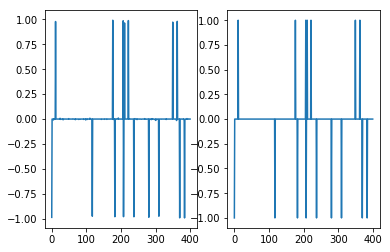

mse:  2.026700529025995e-05


In [11]:
plt.subplot(1, 2, 1)
plt.plot(coeffs)
plt.subplot(1, 2, 2)
plt.plot(x)
plt.show()
print('mse: ',np.sum((coeffs.reshape(x.shape)-x)**2)/len(x))